# Домашняя работа 5. Линейная регрессия. (33 балла)

> Линейная регрессия - это не повод для затяжной депрессии.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #5: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 27.11.2017 01:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 30.11.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [Первый конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture02-linregr.pdf)
- [Второй конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture03-linregr.pdf)
- [Теория из курса ODS](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_notebooks/topic04_linear_models/topic4_linear_models_part1_mse_likelihood_bias_variance.ipynb)
- [Материалы из курса от МФТИ](https://www.coursera.org/specializations/machine-learning-data-analysis)
- [Статья про лин.рег. от ODS на habrahabr](https://habrahabr.ru/company/ods/blog/323890/)

## Данные

Возьмем датасет о стоимости домов: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Там же читайте описание данных.

Целевой переменной будет `SalePrice`. То есть мы будем предсказывать стоимость жилья на основе его характеристик. Это задание будет не то чтобы про линейную регрессию, но про попытку построить модель для предсказания цен на дом. В принципе я бы мог еще добавить заданий на более тщательный отбор признаков, логарифмирование признаков у которых сильное смещение "скоса"(skew). Можно было бы анализировать и выпрямлять распределение целевой переменной. Можно было бы генерировать новые признаки из существующих, строить ансаибли моделей. Но тут мы ограничимся пока что.......

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data/house_prices.csv.gz', index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
assert df.shape == (1460, 80)

In [4]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## 1.0 Анализ целевого признака (3 балла)

Удостоверимся, что раcпределение целевого признака "хорошее", без странных выбросов. В идеале мы хотим видеть нормальное распределени или достаточно похожее на него, без очень длинных "хвостов" выбросов.

_Почему требуется нормальность распределения: ищите объяснения линейной регресси через алгоритмы максимизации правдоподобия. В итоге, грубо говоря, суть сводится к тому, что с ростом объема выборки, оценка максимального правдоподобия лучше описывает нормальное распределение._

[Коэффициент эксцесса](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%8D%D0%BA%D1%81%D1%86%D0%B5%D1%81%D1%81%D0%B0) показывает степень остроты пика распределения случайной величины. Для нормального распределения он равен `0`. Если хвосты распределения «тяжелее», а пик более «приплюснутый», чем у нормального распределения, то коэффициент < 0. А если хвосты легкие, то больше 0. В нашем случае должно получиться околов `6.5`.

Задание: 
- Нарисуйте график распределения `SalePrice`, используйте аргумент `fit=scipy.stats.norm`, чтобы нарисовать предполагаемое нормальное распределение. Напечатайте значение коэффициент эксцесса `kurtosis` для этого признака.
- Нарисуйте график [scipy.stats.probplot](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.probplot.html) - он покажет нам реальные квантили выборки и теоретические. По нему можно видеть, на сколько много выьросов и на сколько выборка предсказуема.
- Что вы можете сказать по поводу выборки основываясь на `probplot`.  [wiki](https://en.wikipedia.org/wiki/Normal_probability_plot)

kurtosis for SalePrice: 6.509812011089439


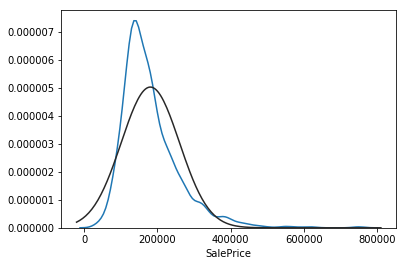

In [5]:
from scipy.stats import norm
sns.distplot(df['SalePrice'], fit=norm, hist=False)
from scipy.stats import kurtosis
print("kurtosis for SalePrice:",kurtosis(df['SalePrice']))

Перекос вправо: вероятностный график выборки имеет форму перевернутой С, что свидетельствует о положительной ассиметрии распределения


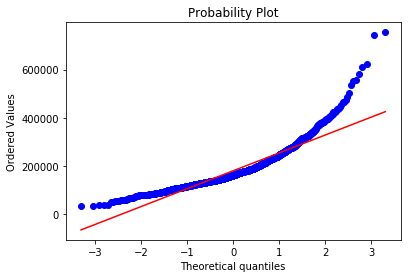

In [6]:
from scipy import stats
stats.probplot(df['SalePrice'], plot=plt);
print("Перекос вправо: вероятностный график выборки имеет форму перевернутой С, что свидетельствует о положительной ассиметрии распределения")

## 1.2 Анализ некоторых зависимостей (3 балла)

У нас очень много разных признаков. Любопытно построить разные графики. Позаботьтесь о красоте и наглядности графиков, сделайте так, чтобы они были большие и их можно было прочесть. Даже подписи на графиках должны быть читаемые!!

Задания: Постройте графики, отражающие зависимости этих признаков:
- дата постройки дома и его стоимости
- "качество дома и материалов" и его стоимости
- площадь дома и стоимость

Hints: Вспомните про boxplot, jointplot, lmplot...

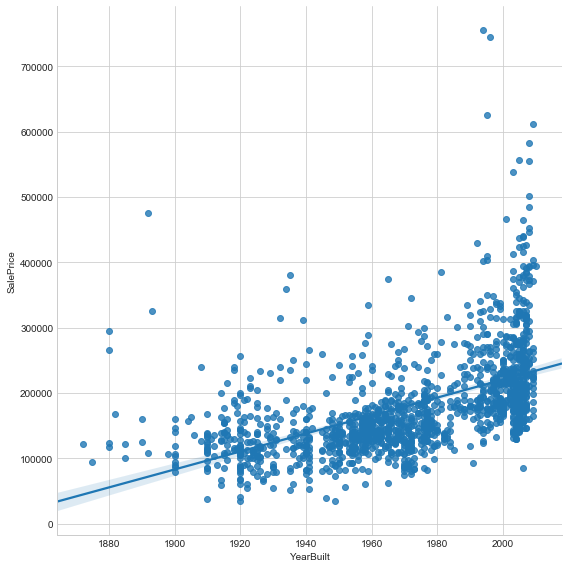

In [7]:
sns.set_style("whitegrid")
sns.lmplot(x='YearBuilt', y='SalePrice', data=df, size=8);

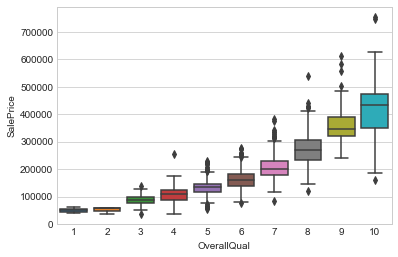

In [8]:
sns.boxplot(x='OverallQual', y='SalePrice', data=df);

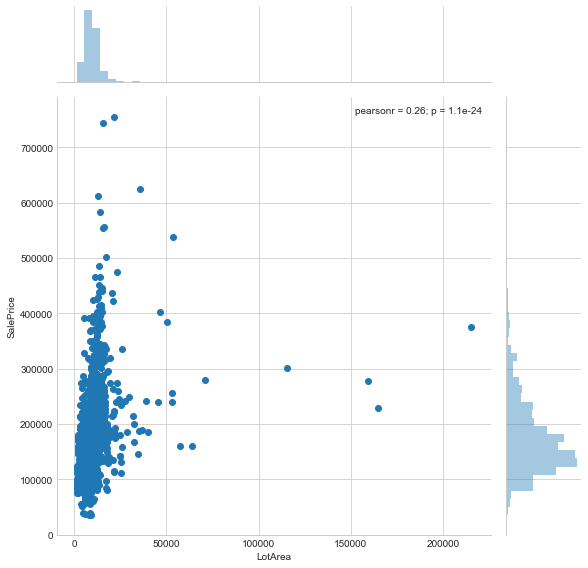

In [9]:
sns.jointplot(x='LotArea', y='SalePrice', data=df, size=8);

## 1.2 Heatmap (3 балла)

Судя по предыдущим графикам, есть некоторые линейные зависимости. Но строить по графику на каждый признак из 80 штук немного долго и не наглядно. Постройте красивый график корреляции всех признаков. Используйте цвета `RdYlGn`, так будет нагляднее. Не забудьте применить маску, чтобы убрать дублирующую половину матрицы.

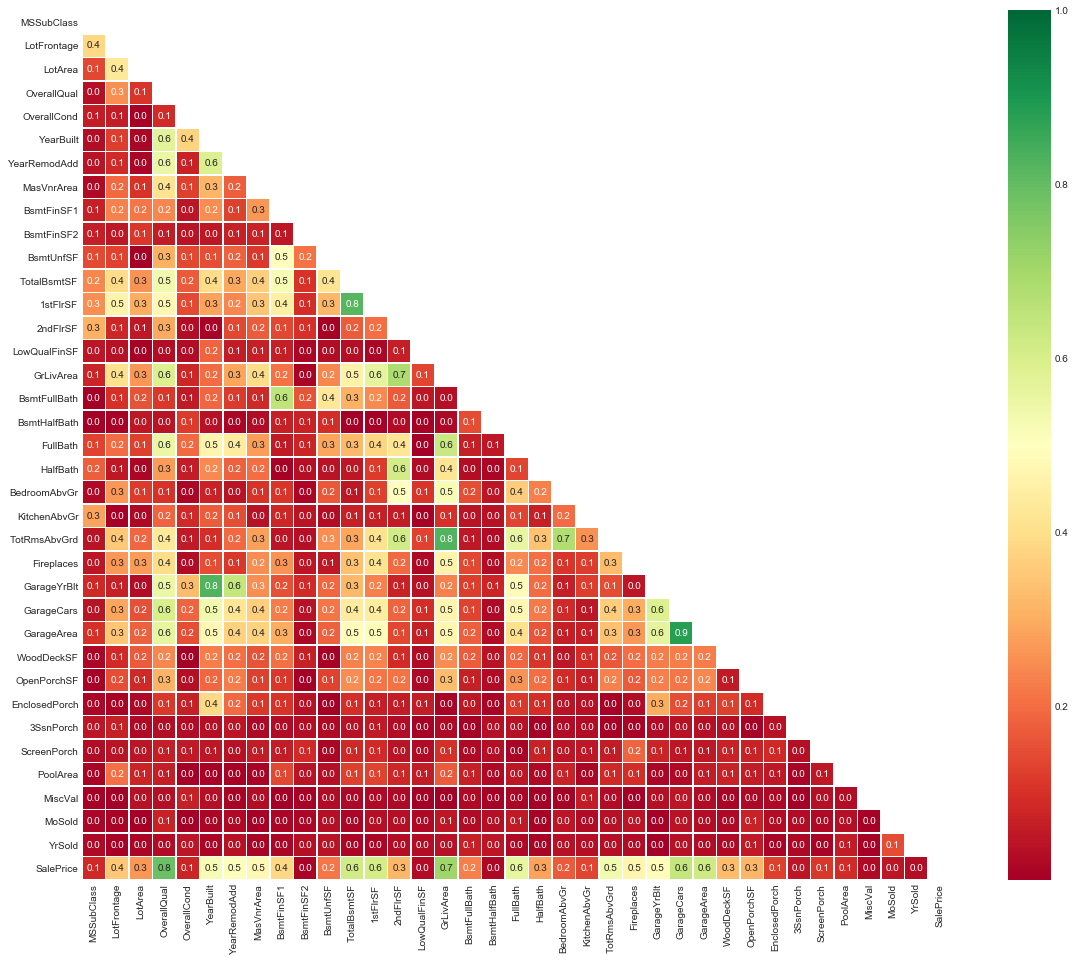

In [10]:
corr = np.abs(df.corr())
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(corr, cmap='RdYlGn', square=True, linewidths=.5, mask=mask, annot=True, fmt=".1f")

Большая матрица 38x38 ячеек. И мы видим, там есть сильно коррелируемые объекты с нашей целевой переменной. 

- Нарисуйте крупно heatmap этих сильно коррелируемых объектов( больше 0.5 по абсолютному значению) и сделайте так, чтобы в каждой ячейке было значение корреляции. 
- Выведите список этих сильно коррелируемых признаков.

Запомним эти признаки!

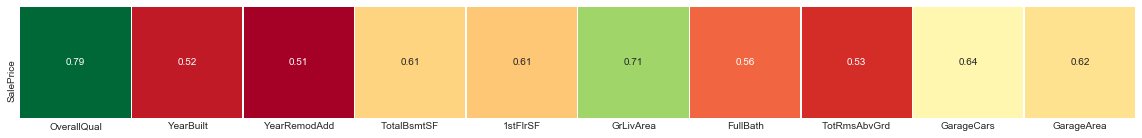

In [11]:
cor = corr[(corr['SalePrice']>0.5) & (corr['SalePrice']<1.0)][['SalePrice']].T
mask = np.zeros_like(cor, dtype=np.bool)
f, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(cor, cmap='RdYlGn', square=True, linewidths=.5, mask=mask, annot=True, fmt=".2f", cbar=False);

In [12]:
col_strong = cor.columns 
print(list(col_strong))

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea']


## 1.3 Пропущеные данные (3 балла)

Задание:
 - Посчитайте общее количество пропущенных данных по каждому признаку
 - посчитайте долю пропущенных данных выборки
 - удалите из выборки признаки, доля пропущенных которых больще 10%
 - пропущенные категориальные заполните словом 'unknown' (у них dtype object)
 - пропущенные числовые заполните средним (у них dtype float)

Hinst: https://stackoverflow.com/a/38134049/3205200

In [13]:
cnt_na = [df[col].isnull().values.sum() for col in df.columns]
pay_na = cnt_na/df[df.columns[0]].count()
print("Количество пропусков: ", cnt_na)
print("Доля пропусков: ", list(map(float, pay_na)))

df_ = df.copy()
col_na = df_.columns[pay_na>0.1]
df_.drop(col_na, axis=1, inplace=True)
df_.shape

Количество пропусков:  [0, 0, 259, 0, 0, 1369, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 0, 0, 0, 37, 37, 38, 37, 0, 38, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 690, 81, 81, 81, 0, 0, 81, 81, 0, 0, 0, 0, 0, 0, 0, 1453, 1179, 1406, 0, 0, 0, 0, 0, 0]
Доля пропусков:  [0.0, 0.0, 0.1773972602739726, 0.0, 0.0, 0.9376712328767123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005479452054794521, 0.005479452054794521, 0.0, 0.0, 0.0, 0.025342465753424658, 0.025342465753424658, 0.026027397260273973, 0.025342465753424658, 0.0, 0.026027397260273973, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006849315068493151, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4726027397260274, 0.05547945205479452, 0.05547945205479452, 0.05547945205479452, 0.0, 0.0, 0.05547945205479452, 0.05547945205479452, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9952054794520548, 0.8075342465753425, 0.963013698630137, 0.0, 0.0, 0.0, 0

(1460, 74)

In [14]:
df_d = df_.copy()
for col in df_d.columns :
    if df_d[col].dtype=='object' : df_d[col] = df_[col].fillna(value='unknown')  
    elif df_d[col].dtype=='float64' : df_d[col] = df_[col].fillna(value=df_[col].mean())

## 1.4 Категориальные переменные (1 балл)

На сколько вы помните, линейная регрессия не умеет обрабатывать категориальные признаки, так как ей нужны ЧИСЛА. Но не беда, в pandas есть встроенная функция [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html).

Задание:
- сконвертируйте все категориальные признаки(dtype=object) в вектора числовых с помощью get_dummies
- напечатайте сколько у вас теперь признаков
- Положите в переменную X все данные из датасета, кроме целевой переменной. Положите в переменную y только целевую переменную.

In [15]:
df_dum = pd.get_dummies(df_d)
print("Количество признаков после dummy-кодирования: ", len(df_dum.columns))

Количество признаков после dummy-кодирования:  281


In [16]:
X = df_dum.copy()
X.drop(['SalePrice'], axis=1, inplace=True)
y = df_dum.loc[:, 'SalePrice']
print("X.shape: {}, y.shape: {}".format(X.shape, y.shape))

X.shape: (1460, 280), y.shape: (1460,)


## 1.5 Переобучение (3 балла)

Обучим обычную модель без регуляризации [sklearn.linear_model.LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

- Выведите все коэффициенты для каждого признака, отсортировав по возрастанию по модулю значения коэффициента. Используйте print и for, иначе jupyter схлопнет вывод numpy массива. Можете округлить коэффициенты до 2 знаков после запятой.
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)

In [17]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y) 

In [18]:
for coef, col in sorted(zip(reg.coef_, df_dum.columns), key=lambda x: np.abs(x[0])):
    print("{:>10.2f} \t {}".format(coef, col))

      0.11 	 MiscVal
      0.77 	 LotArea
      3.47 	 OpenPorchSF
      4.65 	 EnclosedPorch
     13.37 	 WoodDeckSF
     18.02 	 GarageArea
     18.75 	 MasVnrArea
    -27.06 	 GarageYrBlt
     28.50 	 ScreenPorch
    -31.41 	 MSSubClass
     32.57 	 3SsnPorch
     85.15 	 PoolArea
     97.36 	 YearRemodAdd
    320.65 	 YearBuilt
   -404.00 	 YrSold
   -436.56 	 MoSold
   -618.25 	 BsmtHalfBath
    761.23 	 BsmtFullBath
   1098.15 	 TotRmsAbvGrd
   1128.39 	 HalfBath
   2515.51 	 Fireplaces
  -3314.69 	 BedroomAbvGr
   3585.74 	 FullBath
   4263.42 	 GarageCars
   5700.73 	 OverallCond
   6579.12 	 OverallQual
 -12637.55 	 KitchenAbvGr
378319427.17 	 RoofStyle_Shed
378974307.82 	 RoofMatl_Metal
378977417.38 	 RoofMatl_Tar&Grv
378985949.82 	 RoofMatl_ClyTile
378991374.77 	 RoofMatl_Roll
379038566.45 	 RoofMatl_WdShake
379052471.62 	 RoofMatl_Membran
379080776.06 	 RoofMatl_CompShg
-869833116.30 	 Neighborhood_Somerst
-869844554.21 	 Neighborhood_NWAmes
-869852878.35 	 Neighborhood_NoR

In [19]:
from sklearn.model_selection import cross_val_score
error = abs(np.mean(cross_val_score(reg, X, y, cv=3, scoring='neg_mean_squared_error')))
np.round(error,3)

1104428137.5610001

К счастью в этот раз коэффициенты при признаках не улетели в космос, но всё равно достигли очень больших значений. Например `RoofStyle_Shed` получился в моем случае около `-514961`. А у некоторых признаков коэффициент уже равен 0, хотя не была применена регуляризация.

## 1.6 Ridge и Lasso (4 балла)

- Обучите Lasso и Ridge для разных значений регуляризации alpha
- нарисуйте график значений коэффициентов модели для каждого признака, как мы делали на практике. По оси X будет значение alpha, по Y - значение коэффициента. на графике будет "радуга" из линий разных цветов(линий столько, сколько признаков).
- Нарисуйте гистограмму, в которой по оси Y будет количество коэффициентов, равных 0 (<0.0001) для Loss регресиии, а по оси X - значение коэффициента альфа.

alpha взять от 1 до 500 с каким-нибудь шагом. Но не переборщите, а то долго будете ждать.

In [20]:
from sklearn.linear_model import Lasso, Ridge

alphas = np.arange(1, 500, 5)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

i = 0
for alpha in alphas:
    lasso = Lasso(alpha = alpha, random_state=42)
    lasso.fit(X, y)
    coefs_lasso[i, :] = lasso.coef_
    
    ridge = Ridge(alpha = alpha, random_state=42)
    ridge.fit(X, y)
    coefs_ridge[i, :] = ridge.coef_
    
    i += 1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


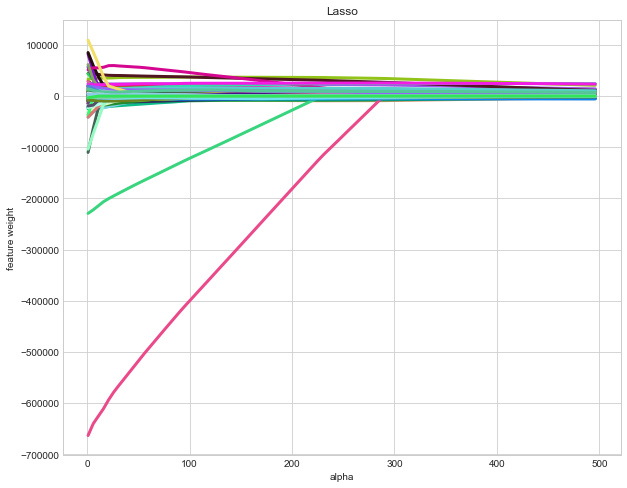

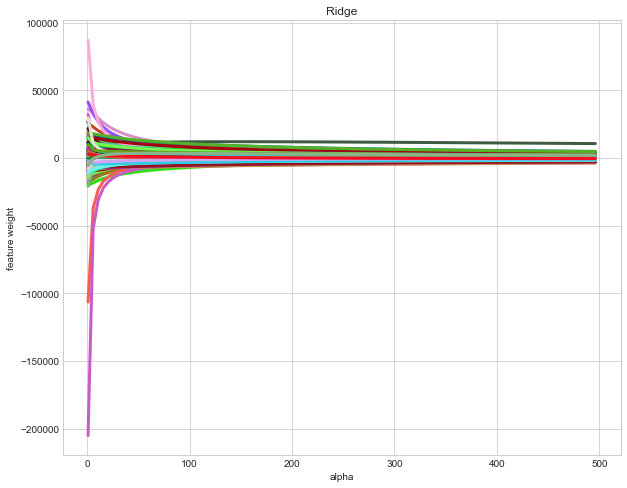

In [21]:
plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_lasso.T, df_dum.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
#plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_ridge.T, df_dum.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3), linewidth=3)
#plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

In [22]:
from itertools import groupby
from itertools import filterfalse
dat = coefs_lasso
dd = [[(key, len(list(gr))) for key, gr in groupby(sorted(dat[i]))] for i in range(dat.shape[0])]
dd_filt = [filterfalse(lambda x: np.abs(x[0])>=0.0001, dd[i]) for i in range(len(dd))]
dd_0 = [np.sum([v for key, v in dd_filt[i]]) for i in range(len(dd_filt))]

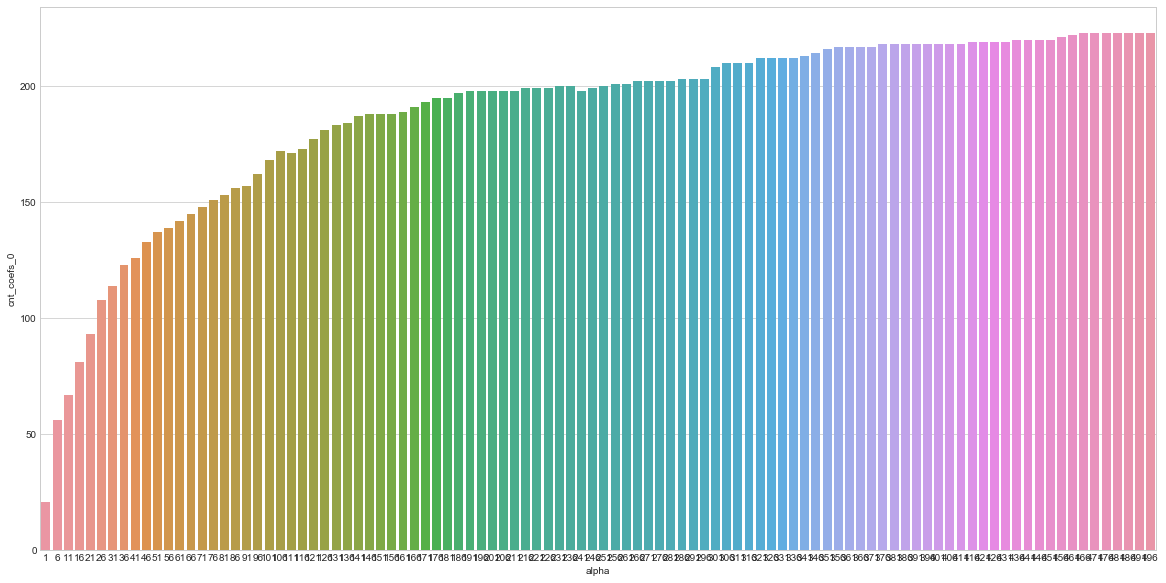

In [23]:
plt.figure(figsize=(20,10))
sns.barplot(x="alpha", y="cnt_coefs_0", data=pd.DataFrame(list(zip(alphas, dd_0)), columns=["alpha", "cnt_coefs_0"]));

## 1.7 Поиск оптимального alpha (6 баллов)

- С помощью метода LassoCV найдите оптимальное значение alpha и напечатайте его, используя разбиение на 5 фолда в кроссвалидации (`cv=5`).
- Нарисуйте график зависимости MSE от alpha (`mse_path_`).
- Нарисуйте длинную гистограмму магнитуда признаков, как в классе, на которой будет показано значение коэффициента для каждого признака. Графк должен быть остортирован по величине коэффициентов. Признаки с нулевыми коэффициентами должны быть удалены.
- Сколько в итоге ненулевых признаков осталось?
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error). Качество должно быть лучше, чем у простой линейной регрессии.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha = 146


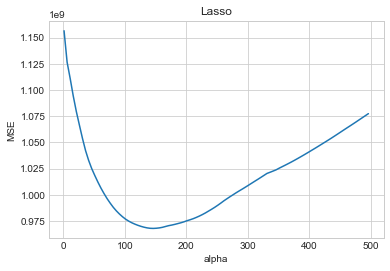

In [24]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=alphas, random_state=42, cv=5)
lasso_cv.fit(X, y)
mean_mse = np.mean(lasso_cv.mse_path_, axis = 1)
plt.plot(lasso_cv.alphas_, mean_mse)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Lasso')
print('alpha = {}'.format(lasso_cv.alpha_))

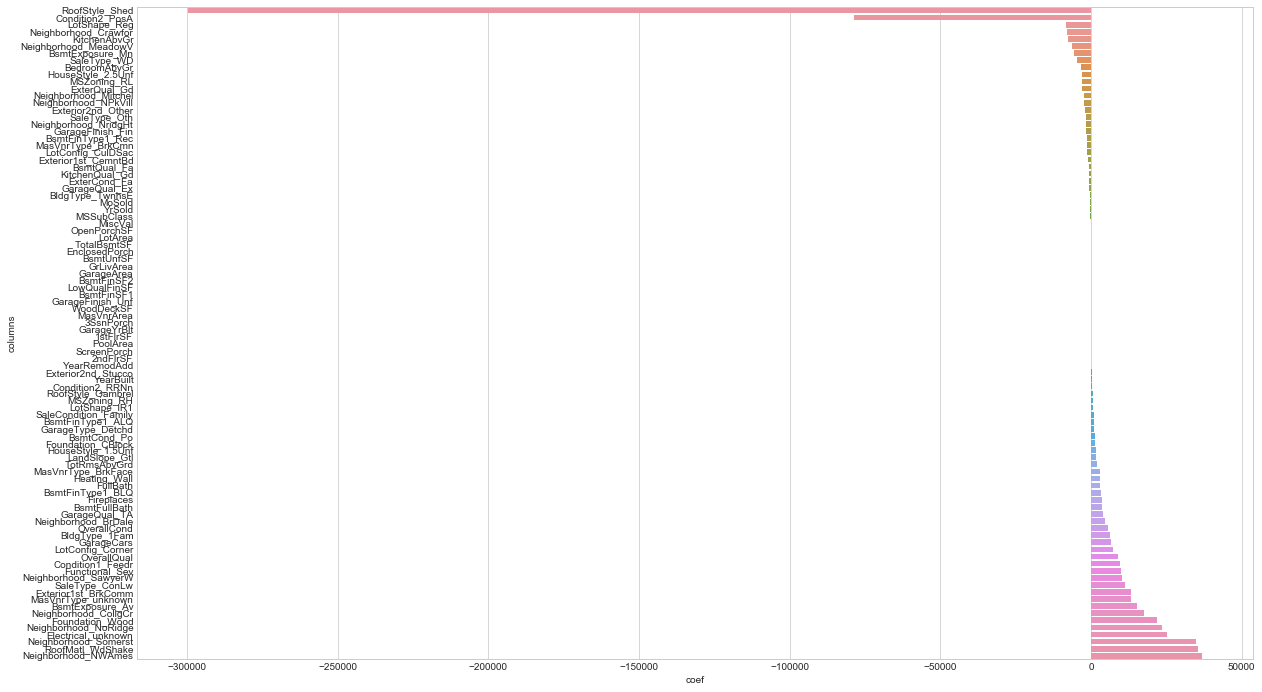

In [25]:
lso_df_dum = pd.DataFrame(list(sorted(zip(lasso_cv.coef_, df_dum.columns))), columns=["coef", "columns"])
lso_df_dum_not0 = lso_df_dum[np.abs(lso_df_dum['coef'])>0.0001]
plt.figure(figsize=(20,12))
sns.barplot(x='coef', y='columns',data=lso_df_dum_not0);


In [26]:
print("Количество ненулевых признаков: ", lso_df_dum_not0.shape[0])

Количество ненулевых признаков:  92


In [27]:
error_lasso = abs(np.mean(cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=5, scoring='neg_mean_squared_error')))
np.round(error_lasso, 3)

967867563.25600004

## 1.8 Предсказание на отложенной выборке (3 балла)

- Используя [sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) разбейте датасет на 2 части - тренировочную и тестовую в соотношении 0.33. Не забудьте перемешать!
- Напечатайте размерность X_train и X_test

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42, shuffle=True)

Теперь, возьмите вашу самую мощную модель(не тренированную!). Запустите её тренировку по тренировочной выборке X_train, y_train с помощью функции `fit`. Постройте предсказания с помощью функции `predict`.

In [29]:
y_pred = Lasso(lasso_cv.alpha_).fit(X_train, y_train).predict(X_test)

Визуализируйте scatter plot предсказанных значений и настоящих (`y_test`). У вас должен получиться график, точки которого расположены приблизительно вдоль некоторой прямой с разбросом. Идеальный предсказатель будет выглядить как набор точек вдоль прямой без разброса.

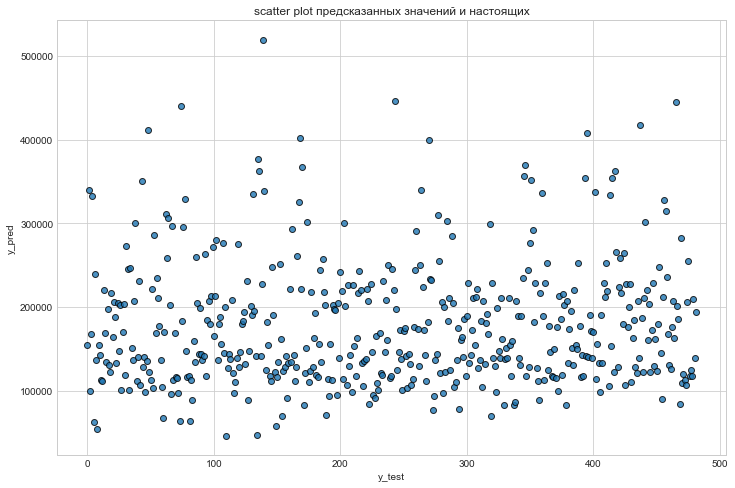

In [30]:
plt.figure(figsize=(12,8))
plt.scatter(x=np.arange(len(y_test)), y=y_pred, edgecolors='black', alpha=0.8)
plt.title('scatter plot предсказанных значений и настоящих')
plt.xlabel('y_test')
plt.ylabel('y_pred')



## 1.9 Ограниченная версия ( 4 балла)

Помните в самом начале мы оставили очень мало признаков по данным из heatmap. Настало время проверить как он себя покажет! К счастью они все сразу числовые, а не категориальные. Переиспользуйте тот дадасет, где вы уже поборолись с пропусками.
Снова выделите отдельно X и y и запустите кроссвалидацию c 5 фолдами по Lasso с `alpha=1`.

In [31]:
X=df_d[col_strong].copy()
y = df_d.loc[:, 'SalePrice']
print("X.shape: {}, y.shape: {}".format(X.shape, y.shape))

X.shape: (1460, 10), y.shape: (1460,)


In [32]:
error_lasso = abs(np.mean(cross_val_score(Lasso(alpha=1), X, y, cv=5, scoring='neg_mean_squared_error')))
np.round(error_lasso, 3)

1529885472.3540001

Можете посмотреть еще много разных примеров обработки этого датасета тут: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

А суть всего этого такова, что в итоге надо кучу времени потратить на подготовку признаков. Смотреть на кучу графиков а потом стакать модели.